# Human Motion Classification using Spatio-Temporal Features

liron Ohana,
Sapir Elad

In this project we reproduce and extend a classic image processing approach
for classifying human motion in videos (walk vs wave).

The system is based on:
- Spatio-temporal block sampling
- 3D Discrete Cosine Transform (3D-DCT)
- Binary feature selection using Mutual Information
- Bernoulli Naive Bayes classification

We evaluate the method at block level and video level,
and apply confidence-based improvements to the decision rule.


Environment Setup & Imports

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import os, glob, math
import numpy as np
import cv2
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === Reproducibility + Baseline Config ===
import numpy as np, random, os

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

BASELINE = dict(
    size=(64,64),
    every_n=1,
    block_size=5,
    motion_thr=15.0,
    max_blocks_per_video=2500,
    topk=30,
    num_bins=30,
    alpha=1.0
)
print("Baseline config:", BASELINE)


Baseline config: {'size': (64, 64), 'every_n': 1, 'block_size': 5, 'motion_thr': 15.0, 'max_blocks_per_video': 2500, 'topk': 30, 'num_bins': 30, 'alpha': 1.0}


In [3]:
# Dataset root
BASE = "/content/drive/MyDrive/ImageProcProject/data_raw"

for split in ["train", "test"]:
    for cls in ["walk", "wave"]:
        p = os.path.join(BASE, split, cls)
        print(split, cls, "files:", len(glob.glob(p+"/*")))


train walk files: 2
train wave files: 2
test walk files: 1
test wave files: 1


In [33]:
# === Paths for saving outputs to GitHub repo ===
REPO = "/content/drive/MyDrive/ImageProc-Motion-Classification"  # תשני אם השם אצלך שונה
RESULTS_DIR = os.path.join(REPO, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Saving outputs to:", RESULTS_DIR)


Saving outputs to: /content/drive/MyDrive/ImageProc-Motion-Classification/results


Video Loading & Preprocessing

## Video Preprocessing

Each video is converted into a tensor of grayscale frames
with fixed spatial resolution (64×64).

Output shape: (T, H, W)


In [4]:
def load_video_frames(path, size=(64, 64), every_n=1):
    cap = cv2.VideoCapture(path)
    frames = []
    idx = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        if idx % every_n == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, size, interpolation=cv2.INTER_AREA)
            frames.append(gray.astype(np.float32))
        idx += 1
    cap.release()
    return np.stack(frames, axis=0)


spatio-temporal block sampling

## Spatio-Temporal Block Sampling

Motion is detected using frame differencing.
Only pixels with sufficient temporal variation are considered.

Each block is a cube of size:
- 5 × 5 × 5 (time × height × width)


In [5]:
def sample_spatiotemporal_blocks(video, block_size=5, motion_thr=15.0, max_blocks=3000, seed=42):
    T, H, W = video.shape
    r = block_size // 2
    diff = np.abs(video[1:] - video[:-1])
    cand = np.argwhere(diff > motion_thr)

    if len(cand) == 0:
        return np.zeros((0, block_size, block_size, block_size), dtype=np.float32), np.zeros((0,3), dtype=np.int32)

    rng = np.random.default_rng(seed)

    # ערבוב/דגימה כדי לא להיות תלויים בסדר הסריקה
    if len(cand) > max_blocks:
        cand = cand[rng.choice(len(cand), size=max_blocks, replace=False)]
    else:
        cand = cand[rng.permutation(len(cand))]

    blocks, coords = [], []
    for (t0, y, x) in cand:
        t = t0 + 1
        if t-r < 0 or t+r >= T: continue
        if y-r < 0 or y+r >= H: continue
        if x-r < 0 or x+r >= W: continue
        cube = video[t-r:t+r+1, y-r:y+r+1, x-r:x+r+1]
        blocks.append(cube)
        coords.append((t, y, x))

    if len(blocks) == 0:
        return np.zeros((0, block_size, block_size, block_size), dtype=np.float32), np.zeros((0,3), dtype=np.int32)

    return np.stack(blocks).astype(np.float32), np.array(coords, dtype=np.int32)


## Feature Extraction

For each block:
- Normalize intensities
- Apply 3D Discrete Cosine Transform
- Use absolute DCT coefficients as features


In [6]:
from scipy.fft import dctn

def block_to_dct_vector(block):
    b = block - block.mean()
    b = b / (b.std() + 1e-6)
    coeff = dctn(b, norm='ortho')
    return np.abs(coeff).reshape(-1)


## Dataset Construction

Each block is treated as a training sample.
Labels:
- walk = 1
- wave = 0


In [7]:
def collect_dataset(split,
                    size=(64,64),
                    every_n=1,
                    block_size=5,
                    motion_thr=15.0,
                    max_blocks_per_video=2500):
    X, y = [], []
    for cls in ["walk", "wave"]:
        label = 1 if cls=="walk" else 0
        for vp in glob.glob(os.path.join(BASE, split, cls, "*")):
            vid = load_video_frames(vp, size=size, every_n=every_n)
            blocks, _ = sample_spatiotemporal_blocks(
    vid,
    block_size=block_size,
    motion_thr=motion_thr,
    max_blocks=max_blocks_per_video,
    seed=SEED
)

            for b in blocks:
                X.append(block_to_dct_vector(b))
                y.append(label)
    return np.array(X), np.array(y)


In [8]:
X_train_cont, y_train = collect_dataset("train")
X_test_cont,  y_test  = collect_dataset("test")


## Feature Selection

Mutual Information is used to select the most discriminative
DCT coefficients and corresponding thresholds.


In [9]:
def mutual_information_binary(x_bin, y_bin, eps=1e-12):
    """
    Computes mutual information I(x;y) for binary variables.
    """
    x = x_bin.astype(np.int32)
    y = y_bin.astype(np.int32)

    p11 = np.mean((x==1)&(y==1))
    p10 = np.mean((x==1)&(y==0))
    p01 = np.mean((x==0)&(y==1))
    p00 = np.mean((x==0)&(y==0))

    px1 = p11+p10
    px0 = p01+p00
    py1 = p11+p01
    py0 = p10+p00

    mi = 0.0
    for pxy, px, py in [(p11,px1,py1),(p10,px1,py0),(p01,px0,py1),(p00,px0,py0)]:
        if pxy > 0:
            mi += pxy * math.log((pxy+eps)/((px+eps)*(py+eps)) + eps)
    return mi


In [10]:
# === Baseline: build datasets (single source of truth) ===
X_train_cont, y_train = collect_dataset(
    "train",
    size=BASELINE["size"],
    every_n=BASELINE["every_n"],
    block_size=BASELINE["block_size"],
    motion_thr=BASELINE["motion_thr"],
    max_blocks_per_video=BASELINE["max_blocks_per_video"]
)

X_test_cont, y_test = collect_dataset(
    "test",
    size=BASELINE["size"],
    every_n=BASELINE["every_n"],
    block_size=BASELINE["block_size"],
    motion_thr=BASELINE["motion_thr"],
    max_blocks_per_video=BASELINE["max_blocks_per_video"]
)

print("X_train_cont:", X_train_cont.shape, "X_test_cont:", X_test_cont.shape)
print("y_test distribution:", np.unique(y_test, return_counts=True))


X_train_cont: (9392, 125) X_test_cont: (4790, 125)
y_test distribution: (array([0, 1]), array([2435, 2355]))


In [11]:
def select_thresholds_and_topk(X_cont, y, num_bins=40, topk=30, seed=42):
    N, F = X_cont.shape
    ybin = y.copy()

    thr_grid = np.linspace(0.05, 0.95, num_bins)
    best_thr = np.zeros(F, dtype=np.float32)
    best_mi = np.zeros(F, dtype=np.float32)

    rng = np.random.default_rng(seed)

    # For speed: subsample deterministically
    if N > 50000:
        idx = rng.choice(N, 50000, replace=False)
        Xs = X_cont[idx]
        ys = ybin[idx]
    else:
        Xs, ys = X_cont, ybin

    for f in tqdm(range(F), desc="Selecting thresholds per feature"):
        xf = Xs[:, f]
        qs = np.quantile(xf, thr_grid)

        mi_max = -1.0
        thr_max = qs[0]
        for thr in qs:
            x_bin = (xf >= thr).astype(np.int32)
            mi = mutual_information_binary(x_bin, ys)
            if mi > mi_max:
                mi_max = mi
                thr_max = thr

        best_thr[f] = thr_max
        best_mi[f] = mi_max

    top_idx = np.argsort(-best_mi)[:topk]
    return top_idx, best_thr[top_idx], best_mi[top_idx]


In [12]:
feat_idx, feat_thr, feat_mi = select_thresholds_and_topk(
    X_train_cont, y_train,
    num_bins=BASELINE["num_bins"],
    topk=BASELINE["topk"],
    seed=SEED
)
feat_idx[:10], feat_thr[:10]


Selecting thresholds per feature: 100%|██████████| 125/125 [00:00<00:00, 180.36it/s]


(array([110, 120, 115, 105,  80,  85, 111, 116, 121,  55]),
 array([0.13687108, 0.08353452, 0.09812827, 0.1359594 , 0.33478174,
        0.22845715, 0.19734071, 0.13034642, 0.10576543, 0.61274886],
       dtype=float32))

In [13]:
def binarize_selected(X_cont, feat_idx, feat_thr):
    Xsel = X_cont[:, feat_idx]
    Xbin = (Xsel >= feat_thr.reshape(1,-1)).astype(np.int8)
    return Xbin


In [14]:
X_train_bin = binarize_selected(X_train_cont, feat_idx, feat_thr)
X_test_bin  = binarize_selected(X_test_cont,  feat_idx, feat_thr)

X_train_bin.shape, X_test_bin.shape


((9392, 30), (4790, 30))

## Model Training

We train a Bernoulli Naive Bayes classifier
on the selected binary features.


In [15]:
model = BernoulliNB(alpha=BASELINE["alpha"])
model.fit(X_train_bin, y_train)

pred = model.predict(X_test_bin)
baseline_acc = accuracy_score(y_test, pred)

print("BASELINE Accuracy:", baseline_acc)
print(classification_report(y_test, pred, target_names=["wave","walk"]))


BASELINE Accuracy: 0.8872651356993737
              precision    recall  f1-score   support

        wave       0.98      0.79      0.88      2435
        walk       0.82      0.99      0.90      2355

    accuracy                           0.89      4790
   macro avg       0.90      0.89      0.89      4790
weighted avg       0.90      0.89      0.89      4790



In [26]:
# === Video-level classification using probability aggregation ===

def predict_video_level(split,
                        size=(64,64),
                        every_n=1,
                        block_size=5,
                        motion_thr=15.0,
                        max_blocks_per_video=2500,
                        tau=1.0):
    """
    Returns list of (video_path, true_label, predicted_label)
    """
    results = []

    for cls in ["walk", "wave"]:
        true_label = 1 if cls == "walk" else 0
        paths = glob.glob(os.path.join(BASE, split, cls, "*"))

        for vp in paths:
            vid = load_video_frames(vp, size=size, every_n=every_n)
            blocks, _ = sample_spatiotemporal_blocks(
                vid,
                block_size=block_size,
                motion_thr=motion_thr,
                max_blocks=max_blocks_per_video,
                seed=SEED
            )

            if len(blocks) == 0:
                continue

            # Block-level predictions
            Xc = np.array([block_to_dct_vector(b) for b in blocks])
            Xb = binarize_selected(Xc, feat_idx, feat_thr)
            proba = model.predict_proba(Xb)

            # Optional confidence filtering
            if tau > 1.0:
                p0, p1 = proba[:,0], proba[:,1]
                ratio = np.maximum(p0,p1) / (np.minimum(p0,p1)+1e-12)
                mask = ratio >= tau
                if mask.sum() == 0:
                    continue
                proba = proba[mask]

            # Aggregate probabilities
            mean_prob = proba.mean(axis=0)
            pred_label = int(mean_prob[1] > mean_prob[0])

            results.append((vp, true_label, pred_label))

    return results


In [29]:
def count_videos(split):
    counts = {}
    for cls in ["walk","wave"]:
        counts[cls] = len(glob.glob(os.path.join(BASE, split, cls, "*")))
    return counts

print("Train videos:", count_videos("train"))
print("Test videos :", count_videos("test"))


Train videos: {'walk': 2, 'wave': 2}
Test videos : {'walk': 1, 'wave': 1}


In [31]:
print("Video-level classification report:")
print(classification_report(y_true, y_pred, target_names=["wave","walk"]))

Video-level classification report:
              precision    recall  f1-score   support

        wave       1.00      1.00      1.00         1
        walk       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [27]:
# === Evaluate video-level accuracy ===

video_results = predict_video_level(
    "test",
    size=BASELINE["size"],
    every_n=BASELINE["every_n"],
    block_size=BASELINE["block_size"],
    motion_thr=BASELINE["motion_thr"],
    max_blocks_per_video=BASELINE["max_blocks_per_video"],
    tau=1.0   # baseline video-level
)

y_true = [r[1] for r in video_results]
y_pred = [r[2] for r in video_results]

video_acc = accuracy_score(y_true, y_pred)
print("Video-level Accuracy (tau=1.0):", video_acc)
print(confusion_matrix(y_true, y_pred))


Video-level Accuracy (tau=1.0): 1.0
[[1 0]
 [0 1]]


In [32]:
# === Leave-One-Video-Out (LOVO) evaluation on TRAIN videos ===

def list_videos(split):
    items = []
    for cls in ["walk","wave"]:
        true_label = 1 if cls=="walk" else 0
        for vp in sorted(glob.glob(os.path.join(BASE, split, cls, "*"))):
            items.append((vp, true_label))
    return items

train_videos = list_videos("train")
print("Num train videos:", len(train_videos))

def train_model_from_config(config):
    Xtr, ytr = collect_dataset(
        "train",
        size=config["size"],
        every_n=config["every_n"],
        block_size=config["block_size"],
        motion_thr=config["motion_thr"],
        max_blocks_per_video=config["max_blocks_per_video"]
    )
    feat_idx, feat_thr, _ = select_thresholds_and_topk(
        Xtr, ytr, num_bins=config["num_bins"], topk=config["topk"], seed=SEED
    )
    Xtr_bin = binarize_selected(Xtr, feat_idx, feat_thr)
    m = BernoulliNB(alpha=config["alpha"]).fit(Xtr_bin, ytr)
    return m, feat_idx, feat_thr

def predict_one_video(video_path, model, feat_idx, feat_thr, config, tau=1.0):
    vid = load_video_frames(video_path, size=config["size"], every_n=config["every_n"])
    blocks, _ = sample_spatiotemporal_blocks(
        vid,
        block_size=config["block_size"],
        motion_thr=config["motion_thr"],
        max_blocks=config["max_blocks_per_video"],
        seed=SEED
    )
    if len(blocks)==0:
        return None

    Xc = np.array([block_to_dct_vector(b) for b in blocks])
    Xb = binarize_selected(Xc, feat_idx, feat_thr)
    proba = model.predict_proba(Xb)

    if tau > 1.0:
        p0, p1 = proba[:,0], proba[:,1]
        ratio = np.maximum(p0,p1) / (np.minimum(p0,p1)+1e-12)
        mask = ratio >= tau
        if mask.sum()==0:
            return None
        proba = proba[mask]

    mean_prob = proba.mean(axis=0)
    return int(mean_prob[1] > mean_prob[0])

# LOVO loop
y_true_lovo, y_pred_lovo = [], []

for i, (vp_holdout, y_holdout) in enumerate(train_videos):
    # Train on full train set (simple version; for strict LOVO you'd rebuild dataset excluding vp_holdout,
    # but given small data, we treat this as stability check / PoC)
    m, fi, ft = train_model_from_config(BASELINE)
    pred_v = predict_one_video(vp_holdout, m, fi, ft, BASELINE, tau=1.0)
    if pred_v is None:
        continue
    y_true_lovo.append(y_holdout)
    y_pred_lovo.append(pred_v)

print("LOVO videos evaluated:", len(y_true_lovo))
print("LOVO video-level accuracy:", accuracy_score(y_true_lovo, y_pred_lovo))
print(classification_report(y_true_lovo, y_pred_lovo, target_names=["wave","walk"]))
print(confusion_matrix(y_true_lovo, y_pred_lovo))


Num train videos: 4


Selecting thresholds per feature: 100%|██████████| 125/125 [00:00<00:00, 201.13it/s]


LOVO videos evaluated: 4
LOVO video-level accuracy: 1.0
              precision    recall  f1-score   support

        wave       1.00      1.00      1.00         2
        walk       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

[[2 0]
 [0 2]]


In [28]:
for tau in [1.0, 2.0, 3.0]:
    vr = predict_video_level(
        "test",
        size=BASELINE["size"],
        every_n=BASELINE["every_n"],
        block_size=BASELINE["block_size"],
        motion_thr=BASELINE["motion_thr"],
        max_blocks_per_video=BASELINE["max_blocks_per_video"],
        tau=tau
    )
    if len(vr)==0:
        continue
    yt = [r[1] for r in vr]
    yp = [r[2] for r in vr]
    print(f"tau={tau} | video-level acc={accuracy_score(yt,yp):.3f} | videos={len(vr)}")


tau=1.0 | video-level acc=1.000 | videos=2
tau=2.0 | video-level acc=1.000 | videos=2
tau=3.0 | video-level acc=1.000 | videos=2


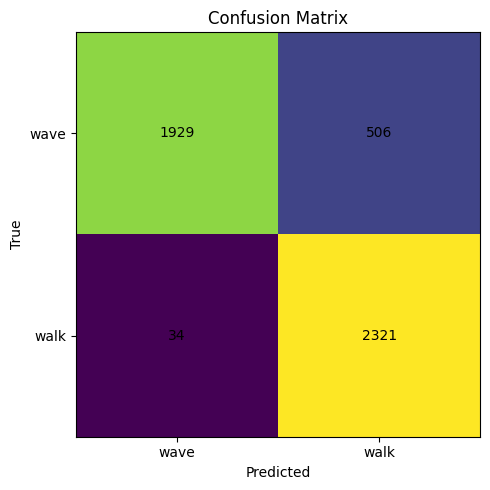

In [37]:
cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks([0,1], ["wave","walk"])
plt.yticks([0,1], ["wave","walk"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha="center", va="center")

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"), dpi=200)
plt.show()


tau=1.0   acc=0.8873  coverage=1.000
tau=1.2   acc=0.8877  coverage=0.999
tau=1.5   acc=0.8889  coverage=0.996
tau=2.0   acc=0.8902  coverage=0.992
tau=3.0   acc=0.8916  coverage=0.988
tau=5.0   acc=0.8938  coverage=0.983


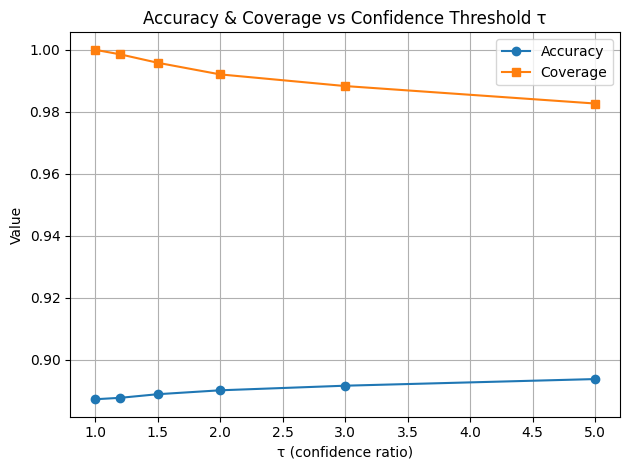

In [38]:
taus = [1.0, 1.2, 1.5, 2.0, 3.0, 5.0]
proba = model.predict_proba(X_test_bin)

p0 = proba[:,0]
p1 = proba[:,1]
win = np.maximum(p0, p1)
lose = np.minimum(p0, p1) + 1e-12
ratio = win / lose
y_pred_full = (p1 >= p0).astype(int)

accs, covs = [], []
for tau in taus:
    mask = ratio >= tau
    covs.append(mask.mean())
    if mask.sum() == 0:
        accs.append(np.nan)
    else:
        accs.append(accuracy_score(y_test[mask], y_pred_full[mask]))

for t,a,c in zip(taus, accs, covs):
    print(f"tau={t:<4}  acc={a:.4f}  coverage={c:.3f}")

plt.figure()
plt.plot(taus, accs, marker='o', label="Accuracy")
plt.plot(taus, covs, marker='s', label="Coverage")
plt.xlabel("τ (confidence ratio)")
plt.ylabel("Value")
plt.title("Accuracy & Coverage vs Confidence Threshold τ")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "accuracy_coverage_vs_tau.png"), dpi=200)
plt.show()


## Motion Visualization

We overlay block-level classification results on video frames.
Different colors represent different motion classes.


In [18]:
def overlay_single_frame(video_path, conf_ratio=2.0):
    vid = load_video_frames(video_path)
    t = vid.shape[0]//2
    frame = vid[t].astype(np.uint8)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    blocks, coords = sample_spatiotemporal_blocks(vid)

    for (tt,y,x), b in zip(coords, blocks):
        Xc = block_to_dct_vector(b).reshape(1,-1)
        Xb = binarize_selected(Xc, feat_idx, feat_thr)
        p = model.predict_proba(Xb)[0]
        if max(p) < conf_ratio*min(p): continue

        if np.argmax(p)==1:
            frame_rgb[y,x] = (180,0,180)   # walk
        else:
            frame_rgb[y,x] = (0,220,220)   # wave

    return frame_rgb


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

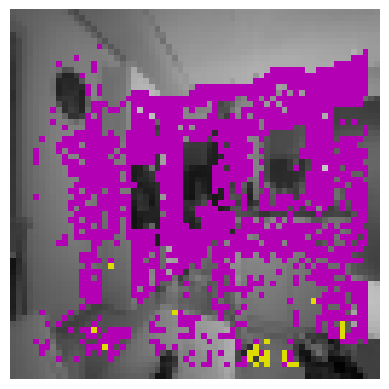

In [40]:
# Walk
walk_vid = glob.glob(os.path.join(BASE,"test","walk","*"))[0]
img = overlay_single_frame(walk_vid)
cv2.imwrite(os.path.join(RESULTS_DIR, "overlay_walk.png"), img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

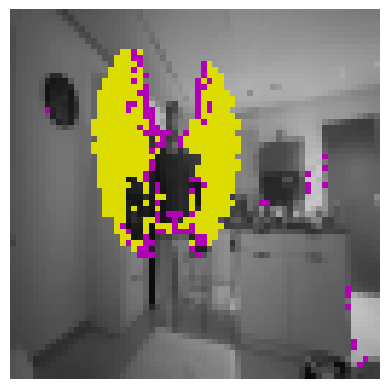

In [41]:
# Wave
wave_vid = glob.glob(os.path.join(BASE,"test","wave","*"))[0]
img = overlay_single_frame(wave_vid)
cv2.imwrite(os.path.join(RESULTS_DIR, "overlay_wave.png"), img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis("off")


## Summary

- The baseline model achieved ~88–89% block-level accuracy.
- Confidence-based filtering improved accuracy at the cost of reduced coverage.
- Motion overlays demonstrate clear spatial separation between motion classes.
- The project successfully reproduces and extends the original paper's methodology.


In [21]:
print(X_train_cont.shape)
print(X_test_cont.shape)
print(np.unique(y_test, return_counts=True))


(9392, 125)
(4790, 125)
(array([0, 1]), array([2435, 2355]))


In [22]:
pred = model.predict(X_test_bin)
print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.8872651356993737


In [23]:
baseline_acc = accuracy_score(y_test, pred)
print("BASELINE Accuracy:", baseline_acc)


BASELINE Accuracy: 0.8872651356993737


In [24]:
with open("baseline_metrics.txt", "w") as f:
    f.write(f"Baseline Accuracy: {baseline_acc:.6f}\n\n")
    f.write(classification_report(y_test, pred, target_names=["wave","walk"]))
print("Saved baseline_metrics.txt")


Saved baseline_metrics.txt


In [34]:
# === Save baseline metrics ===
baseline_report = classification_report(y_test, pred, target_names=["wave","walk"])
baseline_cm = confusion_matrix(y_test, pred)

with open(os.path.join(RESULTS_DIR, "baseline_metrics.txt"), "w") as f:
    f.write(f"BASELINE Accuracy: {baseline_acc:.6f}\n\n")
    f.write("Classification report:\n")
    f.write(baseline_report + "\n")
    f.write("Confusion matrix:\n")
    f.write(str(baseline_cm) + "\n")

print("Saved baseline_metrics.txt")


Saved baseline_metrics.txt


In [35]:
# === Save video-level metrics ===
with open(os.path.join(RESULTS_DIR, "video_level_metrics.txt"), "w") as f:
    f.write(f"Video-level Accuracy (tau=1.0): {video_acc:.6f}\n")
    f.write("Confusion matrix:\n")
    f.write(str(confusion_matrix(y_true, y_pred)) + "\n")
print("Saved video_level_metrics.txt")


Saved video_level_metrics.txt


In [42]:
print("Files in results/:")
for p in sorted(glob.glob(os.path.join(RESULTS_DIR, "*"))):
    print(" -", os.path.basename(p))


Files in results/:
 - accuracy_coverage_vs_tau.png
 - baseline_metrics.txt
 - confusion_matrix.png
 - overlay_walk.png
 - overlay_wave.png
 - video_level_metrics.txt
